In [1]:
%load_ext autoreload
import numpy as np
import seaborn as sns
import os
import ClassificationModelsimplerev1 as ClassificationModelsimple
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2023-03-07 15:33:55.221737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:33:56.182750: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 15:33:56.710762: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 15:34:02.692050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [45]:
#prepare data
df=gpd.read_file('Data/NepalEqUSGSV3.shp')
train_df, test_df = train_test_split(df, test_size=0.30, random_state=42)

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Landslide')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
exai_ds=df_to_dataset(train_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']])
val_ds=df_to_dataset(test_df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
[(train_features, label_batch)] = exai_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of geology:', train_features['GLG'])
print('A batch of targets:', label_batch )

/tmp/ipykernel_145317/2406446408.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/tmp/ipykernel_145317/2406446408.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Every feature: ['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m', 'GLG', 'Landslide']
A batch of geology: tf.Tensor(
[[b'N']
 [b'Ti']
 [b'pC']
 [b'pC']
 [b'Mi']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'N']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'N']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'Ti']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'pC']
 [b'Ti']
 [b'pC']
 [b'pC']
 [b'pC']], shape=(32, 1), dtype=string)
A batch of targets: tf.Tensor([0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0], shape=(32,), dtype=int64)


In [3]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [4]:
all_inputs = []
encoded_features = []

# Numerical features.
numerical_cols=['Est_m', 'Nrt_m', 'HC_m', 'VC_m', 'Slp_m', 'Prc_m', 'NDVI_m', 'PGV_Usgs', 'Sand_m', 'Silt_m', 'Clay_m', 'Bdod_m']
for header in numerical_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, exai_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

categorical_cols = ['GLG']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=exai_ds,
                                               dtype='string',
                                               max_tokens=9)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [13]:

clfmdl=ClassificationModelsimple.LandslideModel()
clfmdl.getclassificationModel(all_inputs=all_inputs, encoded_features=encoded_features)
clfmdl.getOptimizer()
clfmdl.compileModel()
# clfmdl.model.load_weights('checkpointsUSGSv2/')

In [14]:
tf.keras.utils.plot_model(clfmdl.model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
def trainmodel(model,train_ds,val_ds):
    
    NUMBER_EPOCHS = 100
    filepath='TrainedWeights/checkptRev1'
    BATCH_SIZE=32
    
    model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_auc",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch",
        options=None
    )
    print(type(train_ds))
    hist = model.fit(train_ds,
                     epochs=NUMBER_EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=val_ds,
                    #  validation_split=0.2,#auto validate using 20% of random samples at each epoch
                     verbose=1, callbacks=[model_checkpoint_callback],class_weight = {0: 1, 1: 5}

                    )
    return hist


In [32]:
trainmodel(clfmdl.model,exai_ds,val_ds)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/100
357/362 [============================>.] - ETA: 0s - loss: 0.7804 - binary_io_u: 0.5569 - auc: 0.8754 - binary_accuracy: 0.7564

/home/dahala/miniconda3/envs/dlashok/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['Landslide'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 20s 54ms/step - loss: 0.7793 - binary_io_u: 0.5575 - auc: 0.8755 - binary_accuracy: 0.7572 - val_loss: 0.5407 - val_binary_io_u: 0.6007 - val_auc: 0.8802 - val_binary_accuracy: 0.8032
Epoch 2/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7733 - binary_io_u: 0.5645 - auc: 0.8780 - binary_accuracy: 0.7631 - val_loss: 0.5376 - val_binary_io_u: 0.5803 - val_auc: 0.8766 - val_binary_accuracy: 0.7843
Epoch 3/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7700 - binary_io_u: 0.5875 - auc: 0.8778 - binary_accuracy: 0.7858 - val_loss: 0.6000 - val_binary_io_u: 0.5704 - val_auc: 0.8786 - val_binary_accuracy: 0.7706
Epoch 4/100
359/362 [============================>.] - ETA: 0s - loss: 0.7779 - binary_io_u: 0.5850 - auc: 0.8753 - binary_accuracy: 0.7836

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 16s 43ms/step - loss: 0.7772 - binary_io_u: 0.5859 - auc: 0.8758 - binary_accuracy: 0.7840 - val_loss: 0.5121 - val_binary_io_u: 0.5606 - val_auc: 0.8823 - val_binary_accuracy: 0.7617
Epoch 5/100
360/362 [============================>.] - ETA: 0s - loss: 0.7609 - binary_io_u: 0.5776 - auc: 0.8824 - binary_accuracy: 0.7762

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 14s 38ms/step - loss: 0.7612 - binary_io_u: 0.5773 - auc: 0.8823 - binary_accuracy: 0.7760 - val_loss: 0.5015 - val_binary_io_u: 0.5890 - val_auc: 0.8867 - val_binary_accuracy: 0.7893
Epoch 6/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7566 - binary_io_u: 0.5766 - auc: 0.8839 - binary_accuracy: 0.7740 - val_loss: 0.4825 - val_binary_io_u: 0.5764 - val_auc: 0.8793 - val_binary_accuracy: 0.7788
Epoch 7/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7537 - binary_io_u: 0.5644 - auc: 0.8842 - binary_accuracy: 0.7630 - val_loss: 0.5833 - val_binary_io_u: 0.5640 - val_auc: 0.8787 - val_binary_accuracy: 0.7667
Epoch 8/100
362/362 [==============================] - 3s 8ms/step - loss: 0.7594 - binary_io_u: 0.5955 - auc: 0.8820 - binary_accuracy: 0.7931 - val_loss: 0.5082 - val_binary_io_u: 0.5973 - val_auc: 0.8807 - val_binary_accuracy: 0.7984
Epoch 9/100
362/362 [==============================] - 4s 9ms/

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 15s 40ms/step - loss: 0.7363 - binary_io_u: 0.5694 - auc: 0.8891 - binary_accuracy: 0.7654 - val_loss: 0.4509 - val_binary_io_u: 0.5559 - val_auc: 0.8895 - val_binary_accuracy: 0.7565
Epoch 15/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7418 - binary_io_u: 0.5754 - auc: 0.8875 - binary_accuracy: 0.7729 - val_loss: 0.5439 - val_binary_io_u: 0.5592 - val_auc: 0.8863 - val_binary_accuracy: 0.7607
Epoch 16/100
360/362 [============================>.] - ETA: 0s - loss: 0.7310 - binary_io_u: 0.5840 - auc: 0.8917 - binary_accuracy: 0.7793

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 14s 39ms/step - loss: 0.7313 - binary_io_u: 0.5837 - auc: 0.8915 - binary_accuracy: 0.7791 - val_loss: 0.5379 - val_binary_io_u: 0.5576 - val_auc: 0.8911 - val_binary_accuracy: 0.7581
Epoch 17/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7313 - binary_io_u: 0.5819 - auc: 0.8912 - binary_accuracy: 0.7795 - val_loss: 0.6022 - val_binary_io_u: 0.5372 - val_auc: 0.8872 - val_binary_accuracy: 0.7365
Epoch 18/100
362/362 [==============================] - 3s 8ms/step - loss: 0.7318 - binary_io_u: 0.5949 - auc: 0.8903 - binary_accuracy: 0.7904 - val_loss: 0.6833 - val_binary_io_u: 0.5306 - val_auc: 0.8884 - val_binary_accuracy: 0.7294
Epoch 19/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7230 - binary_io_u: 0.5801 - auc: 0.8933 - binary_accuracy: 0.7757 - val_loss: 0.4262 - val_binary_io_u: 0.5773 - val_auc: 0.8808 - val_binary_accuracy: 0.7790
Epoch 20/100
362/362 [==============================] - 4s 

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 16s 42ms/step - loss: 0.7152 - binary_io_u: 0.5955 - auc: 0.8972 - binary_accuracy: 0.7885 - val_loss: 0.5066 - val_binary_io_u: 0.5699 - val_auc: 0.8919 - val_binary_accuracy: 0.7692
Epoch 27/100
362/362 [==============================] - 4s 9ms/step - loss: 0.7048 - binary_io_u: 0.5964 - auc: 0.9001 - binary_accuracy: 0.7891 - val_loss: 0.7319 - val_binary_io_u: 0.5164 - val_auc: 0.8900 - val_binary_accuracy: 0.7139
Epoch 28/100
362/362 [==============================] - 4s 9ms/step - loss: 0.6969 - binary_io_u: 0.5993 - auc: 0.9016 - binary_accuracy: 0.7911 - val_loss: 0.7112 - val_binary_io_u: 0.5423 - val_auc: 0.8893 - val_binary_accuracy: 0.7411
Epoch 29/100
362/362 [==============================] - 4s 11ms/step - loss: 0.6986 - binary_io_u: 0.6076 - auc: 0.9013 - binary_accuracy: 0.7994 - val_loss: 0.3631 - val_binary_io_u: 0.6404 - val_auc: 0.8861 - val_binary_accuracy: 0.8407
Epoch 30/100
362/362 [==============================] - 4s

INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


INFO:tensorflow:Assets written to: TrainedWeights/checkptRev1/assets


362/362 [==============================] - 14s 39ms/step - loss: 0.6702 - binary_io_u: 0.6006 - auc: 0.9088 - binary_accuracy: 0.7911 - val_loss: 0.6186 - val_binary_io_u: 0.5125 - val_auc: 0.8925 - val_binary_accuracy: 0.7103
Epoch 41/100
362/362 [==============================] - 4s 9ms/step - loss: 0.6710 - binary_io_u: 0.6131 - auc: 0.9090 - binary_accuracy: 0.8020 - val_loss: 0.4349 - val_binary_io_u: 0.5870 - val_auc: 0.8877 - val_binary_accuracy: 0.7879
Epoch 42/100
362/362 [==============================] - 4s 9ms/step - loss: 0.6651 - binary_io_u: 0.6067 - auc: 0.9094 - binary_accuracy: 0.7964 - val_loss: 0.4246 - val_binary_io_u: 0.5760 - val_auc: 0.8855 - val_binary_accuracy: 0.7776
Epoch 43/100
362/362 [==============================] - 4s 9ms/step - loss: 0.6791 - binary_io_u: 0.5987 - auc: 0.9063 - binary_accuracy: 0.7898 - val_loss: 0.3733 - val_binary_io_u: 0.6234 - val_auc: 0.8888 - val_binary_accuracy: 0.8208
Epoch 44/100
362/362 [==============================] - 4s 

In [49]:
#predict in test set
y_test=test_df['Landslide'].to_numpy()
preds=clfmdl.model.predict(val_ds)

155/155 [==============================] - 1s 4ms/step


In [50]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
fpr,tpr,thresholds=sklearn.metrics.roc_curve(y_test, preds)


In [51]:
print(sklearn.metrics.auc(fpr,tpr))
print(sklearn.metrics.confusion_matrix(y_test,np.rint(preds)))

0.8836448352802206
[[2839 1171]
 [ 121  829]]


In [53]:
preds2=preds
preds2[preds>0.50]=1
preds2[preds<=0.50]=0
sklearn.metrics.accuracy_score(y_test,preds2)

0.8375

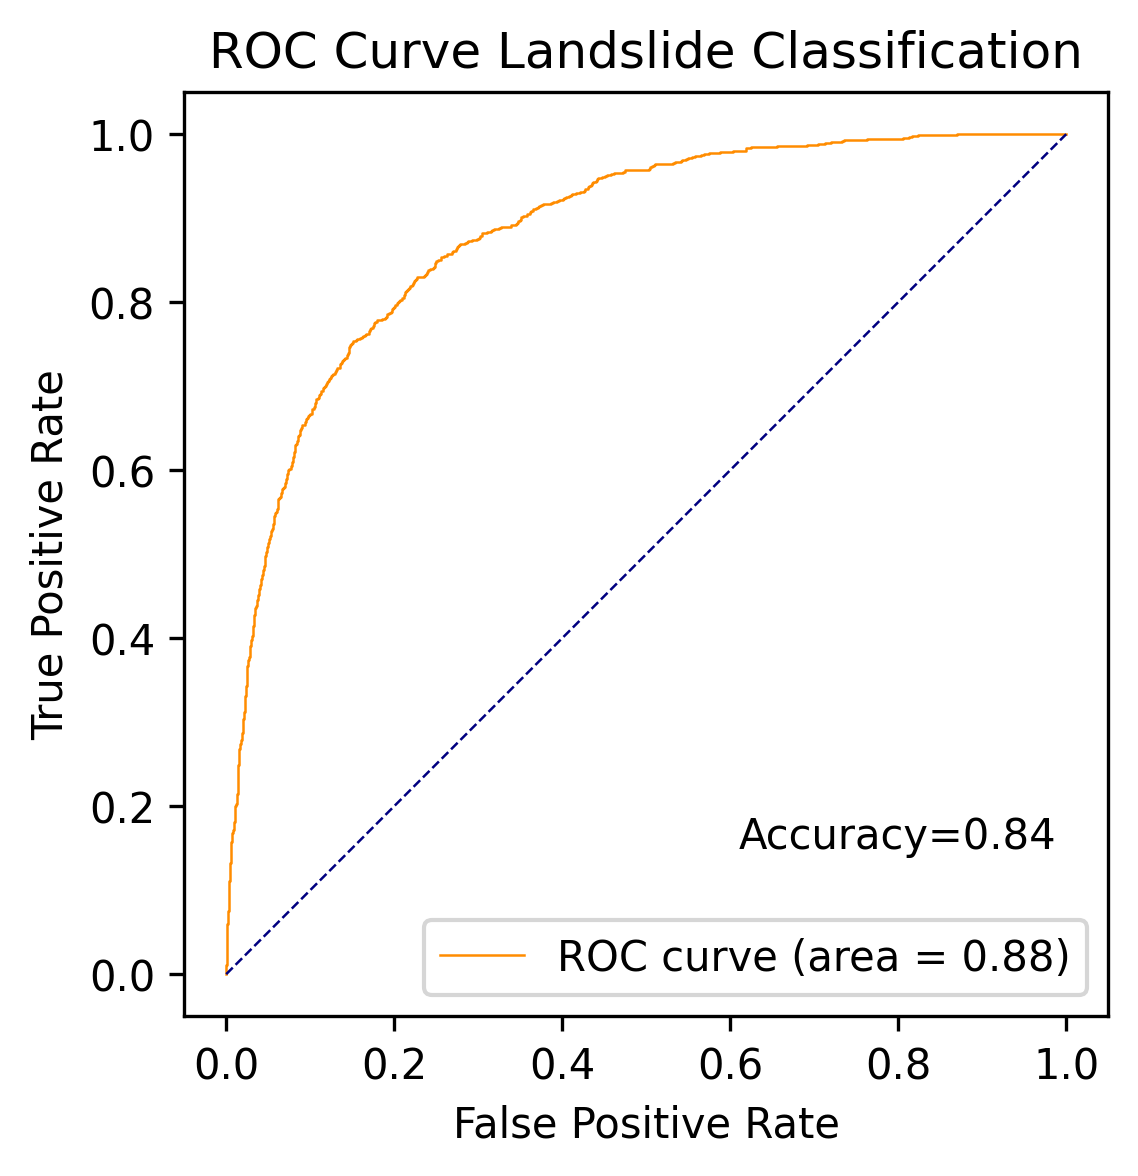

In [80]:
plt.figure(figsize=(4,4),dpi=300)
lw = 0.6
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % 0.88,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Landslide Classification")
plt.text(0.61, 0.15,"Accuracy=0.84")
plt.legend(loc="lower right")
plt.savefig('Exaiplots/rocrev1.pdf')
plt.axis('square')
plt.show()


In [63]:
#confusion  map
all_data=df_to_dataset(df[['Est_m','Nrt_m','HC_m','VC_m','Slp_m','Prc_m','NDVI_m','PGV_Usgs','Sand_m','Silt_m','Clay_m','Bdod_m','GLG','Landslide']],shuffle=False)
preds2=clfmdl.model.predict(all_data)
Ydata=df['Landslide'].to_numpy()
confusiondata=np.empty(Ydata.shape,dtype=object)
confusiondata[np.bitwise_and(Ydata==1,np.rint(preds2.flatten())==1)]='True Positive'
confusiondata[np.bitwise_and(Ydata==0,np.rint(preds2.flatten())==1)]='False Positive'
confusiondata[np.bitwise_and(Ydata==1,np.rint(preds2.flatten())==0)]='False Negative'
confusiondata[np.bitwise_and(Ydata==0,np.rint(preds2.flatten())==0)]='True Negative'

 14/517 [..............................] - ETA: 1s 

/tmp/ipykernel_145317/2406446408.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


517/517 [==============================] - 2s 5ms/step


In [64]:
df['confusion']=confusiondata

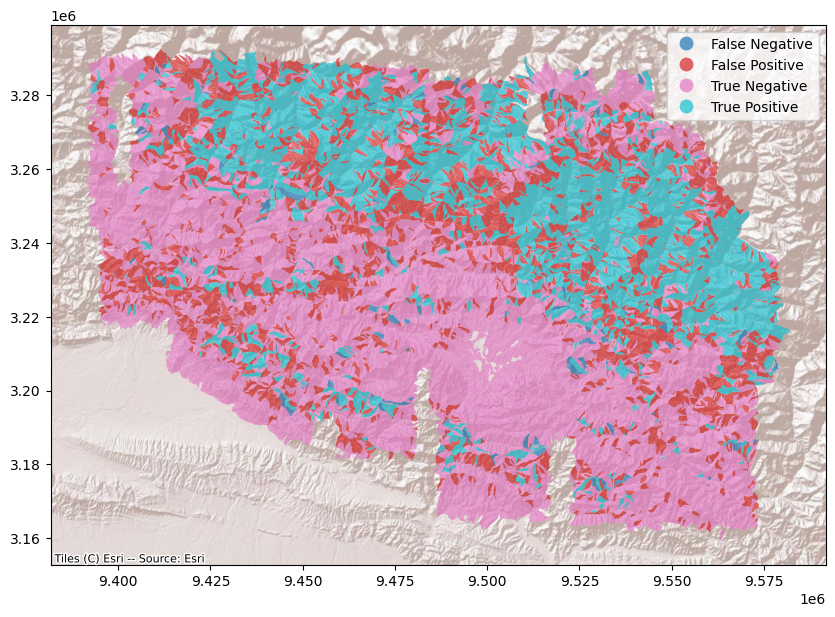

In [67]:
import contextily as cx
df_wm = df.to_crs(epsg=3857)
ax=df_wm.plot(column='confusion',legend=True,figsize=(10, 10), alpha=0.7)
cx.add_basemap(ax,source=cx.providers.Esri.WorldShadedRelief)

In [68]:
ax.get_figure().savefig('confusionmaprev1.pdf',facecolor=ax.get_facecolor())


In [72]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=10,random_state=42,shuffle=True)
kf.get_n_splits(df)

10

In [79]:
for train_index, test_index in kf.split(df):
    df.iloc[train_index]
    df.iloc[test_index]

       Join_Count  TARGET_FID  Ls_count     cat     Est_m     Est_s      HC_m  \
0               1           1         8  216685 -0.645632  0.255463 -0.000191   
1               1           2         6  220824  0.369201  0.274327 -0.000012   
2               1           3         1  279452  0.255292  0.507315  0.000157   
4               1           5         0  250838  0.668613  0.586575  0.000015   
5               1           6         0  236573  0.335477  0.463385 -0.000547   
...           ...         ...       ...     ...       ...       ...       ...   
16527           1       16530         0  277624 -0.219071  0.373176 -0.000253   
16528           1       16531         0  321087 -0.448348  0.559271  0.000975   
16530           1       16533         0  204595  0.002218  0.349860 -0.000284   
16531           1       16534         0  264675  0.726553  0.403563  0.000241   
16532           1       16535         0  272183  0.183036  0.371285  0.000282   

           HC_s    NDVI_m  